### **Importing necessary libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### **Importing dataset for training**

In [2]:
import pathlib

data_dir = pathlib.Path('soil_types')

### **Load data using a Keras utility**

#### Create a dataset

In [3]:
batch_size = 32
img_height = 180
img_width = 180

#### Use 80/20 split for training and validation

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 156 files belonging to 5 classes.
Using 125 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 156 files belonging to 5 classes.
Using 31 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['black_soil', 'cinder_soil', 'laterite_soil', 'peat_soil', 'yellow_soil']


### **Visualize the Data**

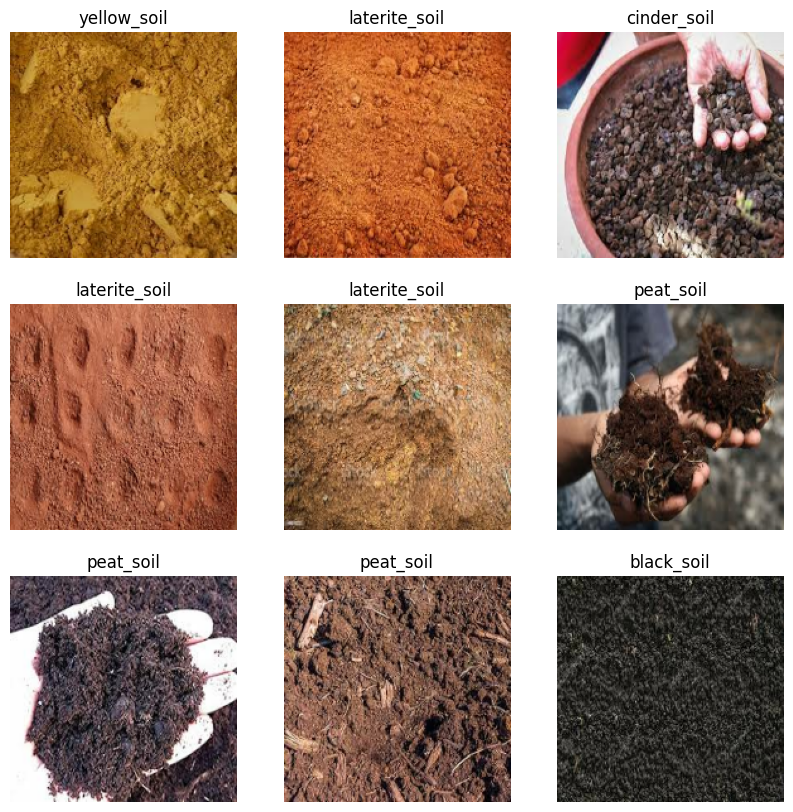

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### **Configure the dataset for performance**

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **Standardize the data**

In [9]:
normalization_layer = layers.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### **Creating the model**

In [11]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

c:\Users\Nabil\anaconda3\envs\tensorflow\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### **Training the Model**

In [14]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.1747 - loss: 1.8877 - val_accuracy: 0.2903 - val_loss: 1.6327
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.3215 - loss: 1.4734 - val_accuracy: 0.3871 - val_loss: 1.3049
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.4006 - loss: 1.2111 - val_accuracy: 0.4516 - val_loss: 1.1585
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.5606 - loss: 0.9538 - val_accuracy: 0.4516 - val_loss: 1.3074
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.5228 - loss: 0.9079 - val_accuracy: 0.5484 - val_loss: 0.9795
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.5725 - loss: 0.8582 - val_accuracy: 0.4194 - val_loss: 1.3153
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.7404 - loss: 0.7060 - val_accuracy: 0.6129 - val_loss: 0.8437
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.8033 - loss: 0.5958 - val_accuracy: 0.6452 - val_loss:

### **Training Results**

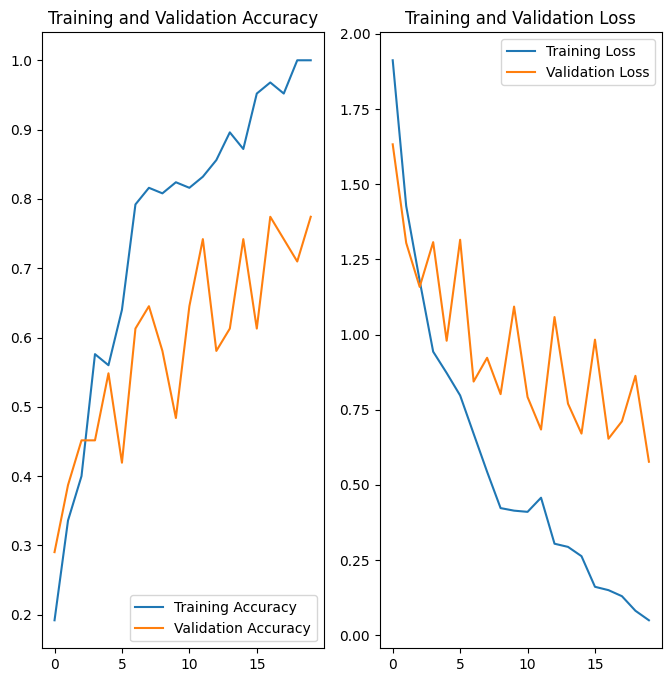

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Reduce Overfitting**

#### Using Data Augmentation & Dropout

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [18]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - accuracy: 0.2544 - loss: 1.6044 - val_accuracy: 0.6129 - val_loss: 1.0771
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.5014 - loss: 1.1757 - val_accuracy: 0.4516 - val_loss: 1.0062
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.6917 - loss: 0.8960 - val_accuracy: 0.7097 - val_loss: 0.7823
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.7120 - loss: 0.7698 - val_accuracy: 0.7419 - val_loss: 0.5376
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.8140 - loss: 0.6412 - val_accuracy: 0.6452 - val_loss: 0.9585
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.8015 - loss: 0.5374 - val_accuracy: 0.7742 - val_loss: 0.6177
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.8693 - loss: 0.3844 - val_accuracy: 0.7097 - val_loss: 0.8031
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.8561 - loss: 0.3486 - val_accuracy: 0.7097 - val_loss:

In [21]:
model.save('soil-classifier.keras')

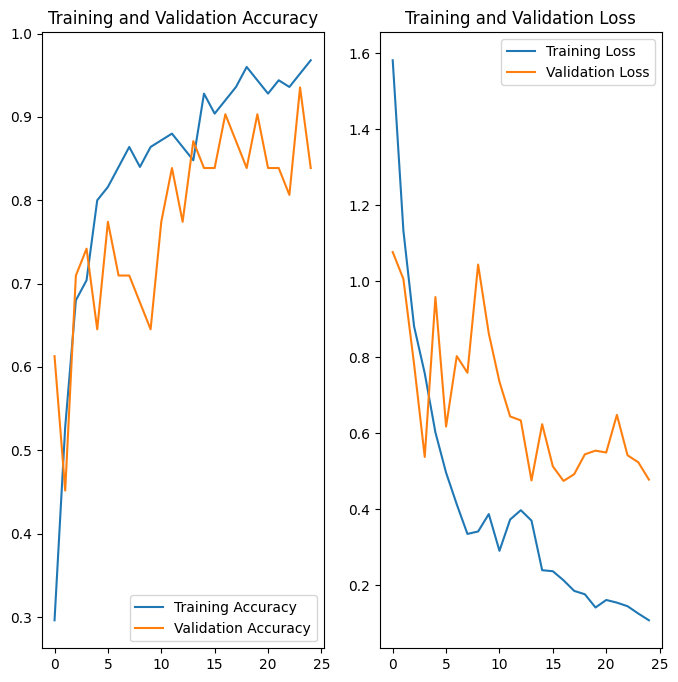

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Testing**

In [23]:
img_path = 'black_soil_ex.jpg'

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
This image most likely belongs to black_soil with a 100.00 percent confidence.
